In [ ]:
# # Uncomment this cell if you want to save plotly figures locally, otherwise you dont have to pip install.
# !pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00


This implementation is inspired from a peper titled "Quantized Neural Networks: Training Neural Networks with Low Precision Weights and Activations", by Itay Hubara, Matthieu Courbariaux, Daniel Soudry, Ran El-Yaniv, Yoshua Bengio. They introduced a new method to train neural networks, where weights and activations are binarized at train time, and then used to compute the gradients.

- This allows in a drastically less memory and power consumption. matrix multiplication is replaced by bitwise operation

# Let's train a CNN model on the CIFAR10 Dataset with PyTorch following the classic approach

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 15
learning_rate = 0.001
batch_size = 32

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:18<00:00, 9.17MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Let's define our CNN model architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Training function
def train(model, train_loader, optimizer, loss_fn, num_epochs):
    losses = []
    accuracies = []
    # model.train() ensures the model functions correctly for training by setting up layers like dropout and batch normalization to work as expected.
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            epoch_loss += loss.item()

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate predictions and update accuracy metrics
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        # Append loss and accuracy to track
        losses.append(avg_epoch_loss)
        accuracies.append(epoch_accuracy)

        # Print epoch summary
        print(f"Epoch: {epoch + 1}/{num_epochs} | Avg Loss: {avg_epoch_loss:.3f} | Accuracy: {epoch_accuracy:.2f}%")

    return losses, accuracies

In [ ]:
# Evaluation

def evaluate(model, test_loader, model_name):
  # Set model to evaluation mode
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)

      # Get predictions (the index of the highest logit corresponds to the predicted class)
      _, predicted = torch.max(outputs, 1)

      # Update total number of correct predictions
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Calculate accuracy
  accuracy = 100 * correct / total
  print(f'Accuracy of the model {model_name} on the test set: {accuracy:.2f}%')
  return accuracy

In [ ]:
# Model initialization
cnn_adam = CNN().to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_adam.parameters(), lr=learning_rate)

print("Training Original CNN...")
cnn_adam_losses, cnn_adam_accuracies = train(cnn_adam, train_loader, optimizer, loss_fn, num_epochs)

Training Original CNN...
Epoch: 1/15 | Avg Loss: 1.500 | Accuracy: 45.37%
Epoch: 2/15 | Avg Loss: 1.139 | Accuracy: 59.66%
Epoch: 3/15 | Avg Loss: 0.975 | Accuracy: 65.40%
Epoch: 4/15 | Avg Loss: 0.869 | Accuracy: 69.43%
Epoch: 5/15 | Avg Loss: 0.793 | Accuracy: 72.19%
Epoch: 6/15 | Avg Loss: 0.739 | Accuracy: 73.98%
Epoch: 7/15 | Avg Loss: 0.688 | Accuracy: 76.00%
Epoch: 8/15 | Avg Loss: 0.643 | Accuracy: 77.42%
Epoch: 9/15 | Avg Loss: 0.608 | Accuracy: 78.63%
Epoch: 10/15 | Avg Loss: 0.571 | Accuracy: 79.87%
Epoch: 11/15 | Avg Loss: 0.543 | Accuracy: 80.83%
Epoch: 12/15 | Avg Loss: 0.512 | Accuracy: 81.79%
Epoch: 13/15 | Avg Loss: 0.484 | Accuracy: 82.93%
Epoch: 14/15 | Avg Loss: 0.456 | Accuracy: 83.86%
Epoch: 15/15 | Avg Loss: 0.433 | Accuracy: 84.44%


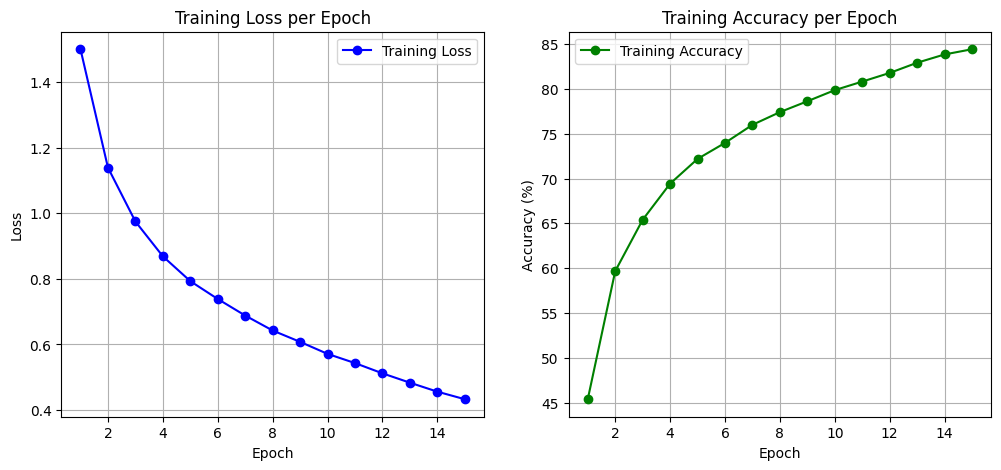

In [ ]:
# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), cnn_adam_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), cnn_adam_accuracies, marker='o', color='g', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.savefig('standard_cnn_trainAcc_loss.png', transparent=True)

plt.show()

In [ ]:
cnn_adam_acc = evaluate(cnn_adam, test_loader, 'CNN Model with Adam optimizer')

Accuracy of the model CNN Model with Adam optimizer on the test set: 72.95%


In [ ]:
# Model initialization
cnn_sgd = CNN().to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=learning_rate)

print("Training Original CNN...")
cnn_sgd_losses, cnn_sgd_train_acc = train(cnn_sgd, train_loader, optimizer, loss_fn, num_epochs)

Training Original CNN...
Epoch: 1 | Loss: 2.298
Epoch: 2 | Loss: 2.284
Epoch: 3 | Loss: 2.222
Epoch: 4 | Loss: 2.146
Epoch: 5 | Loss: 2.036
Epoch: 6 | Loss: 1.932
Epoch: 7 | Loss: 1.913
Epoch: 8 | Loss: 1.649
Epoch: 9 | Loss: 1.261
Epoch: 10 | Loss: 1.761
Epoch: 11 | Loss: 1.903
Epoch: 12 | Loss: 1.612
Epoch: 13 | Loss: 1.717
Epoch: 14 | Loss: 1.845
Epoch: 15 | Loss: 1.613


In [ ]:
cnn_sgd_acc = evaluate(cnn_sgd, test_loader, 'CNN Model with SGD')

Accuracy of the model CNN Model with SGD on the test set: 42.66%


In [ ]:
pytorch_total_params = sum(p.numel() for p in cnn_adam.parameters())
pytorch_total_params

122570

# Let's build our Binarized version which will contains:
  - Weights and activations are constrained to be either +1 or -1.
    - To constrain weights between -1 and 1, we use a deterministic sign function defined as: quantized_x = sign(x) = +1 if x >= 1 else -1.
    - To constrain activations between -1 and 1 we use the HardTanh Activation Function
  - Instead of standard convolution and linear layers, we use a binarized versions (BinarizeConv2d and BinarizeLinear).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# Binarization function with Straight-Through Estimator (STE)
class Binarize(Function):
    @staticmethod
    def forward(ctx, input, quant_mode='det', allow_scale=False):
        # Binarize input deterministically or stochastically
        scale = input.abs().max() if allow_scale else 1

        if quant_mode == 'det':  # Deterministic
            return input.div(scale).sign().mul(scale)
        else:  # Stochastic
            output = input.div(scale).add(1).div(2)
            return output.add_(torch.rand(output.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1).mul(scale)

    @staticmethod
    def backward(ctx, grad_output):
        # Straight-Through Estimator (STE)
        grad_input = grad_output.clone()
        return grad_input, None, None

# Helper function to binarize activations and weights
def binarize(input, quant_mode='det'):
    return Binarize.apply(input, quant_mode)

# Binarized Convolutional Layer with Batch Normalization
class BinarizeConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(BinarizeConv2d, self).__init__(*args, **kwargs)
        self.bn = nn.BatchNorm2d(self.out_channels)

    def forward(self, input):
        if input.size(1) != 3:  # Binarize input except for first layer (e.g., CIFAR-10 with 3 channels)
            input_b = binarize(input)
        else:
            input_b = input

        # Binarize weights
        weight_b = binarize(self.weight)

        # Convolution with binarized weights and input
        out = F.conv2d(input_b, weight_b, None, self.stride, self.padding, self.dilation, self.groups)

        # Apply batch normalization
        out = self.bn(out)

        # Add bias if applicable
        if self.bias is not None:
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out

# Binarized Fully Connected Layer with Batch Normalization
class BinarizeLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super(BinarizeLinear, self).__init__(*args, **kwargs)
        self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self, input):
        # Binarize input except for first layer (e.g., input size of 784 for MNIST)
        if input.size(1) != 784:
            input_b = binarize(input)
        else:
            input_b = input

        # Binarize weights
        weight_b = binarize(self.weight)

        # Linear operation with binarized input and weights
        out = F.linear(input_b, weight_b)

        # Apply batch normalization
        out = self.bn(out)

        # Add bias if applicable
        if self.bias is not None:
            out += self.bias.view(1, -1).expand_as(out)

        return out

# Lets define our Binarized CNN model architecture.

In [ ]:
class BinarizedCNN(nn.Module):
    def __init__(self):
        super(BinarizedCNN, self).__init__()
        self.conv1 = BinarizeConv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = BinarizeConv2d(32, 64, 3)
        self.conv3 = BinarizeConv2d(64, 64, 3)
        self.fc1 = BinarizeLinear(64 * 4 * 4, 64)
        self.fc2 = BinarizeLinear(64, 10)

    def forward(self, x):
        x = F.hardtanh(self.conv1(x))
        x = self.pool(x)
        x = F.hardtanh(self.conv2(x))
        x = self.pool(x)
        x = F.hardtanh(self.conv3(x))

        x = torch.flatten(x, 1)
        x = F.hardtanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# Hinge Loss Function
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss,self).__init__()
        self.margin=1.0

    def hinge_loss(self,input,target):
            #import pdb; pdb.set_trace()
            output=self.margin-input.mul(target)
            output[output.le(0)]=0
            return output.mean()

    def forward(self, input, target):
        return self.hinge_loss(input,target)

In [ ]:
# Training
def train(model, train_loader, optimizer, loss_fn, num_epochs, device):
    losses = []
    model.train()

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Convert integer labels to one-hot encoded format with 10 classes
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass
            outputs = model(images)

            # Compute loss with one-hot encoded targets
            loss = loss_fn(outputs, labels_one_hot)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch + 1} | Loss: {loss.item():.3f}")
        losses.append(loss.item())

    return losses

In [ ]:
# Evaluation for Binarized CNN

def evaluate_binarized(model, test_loader, model_name):
    # Set model to evaluation mode
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Update total number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the model {model_name} on the test set: {accuracy:.2f}%')
    return accuracy

# Binarized CNN with HingeLoss and SGD

In [ ]:
binarized_cnn_hinge_sgd = BinarizedCNN().to(device)

# Loss and optimizer
criterion = HingeLoss()  # Use HingeLoss for BNN (or torch.nn.CrossEntropyLoss() as alternative)
optimizer = torch.optim.SGD(binarized_cnn_hinge_sgd.parameters(), lr=learning_rate)

# Training the Binarized CNN
print("Training Binarized CNN...")
binarized_hinge_sgd_losses = train(binarized_cnn_hinge_sgd, train_loader, optimizer, criterion, num_epochs, device)

Training Binarized CNN...
Epoch: 1 | Loss: 0.996
Epoch: 2 | Loss: 0.968
Epoch: 3 | Loss: 0.924
Epoch: 4 | Loss: 0.934
Epoch: 5 | Loss: 0.929
Epoch: 6 | Loss: 0.913
Epoch: 7 | Loss: 0.907
Epoch: 8 | Loss: 0.910
Epoch: 9 | Loss: 0.900
Epoch: 10 | Loss: 0.903
Epoch: 11 | Loss: 0.901
Epoch: 12 | Loss: 0.903
Epoch: 13 | Loss: 0.900
Epoch: 14 | Loss: 0.900
Epoch: 15 | Loss: 0.902


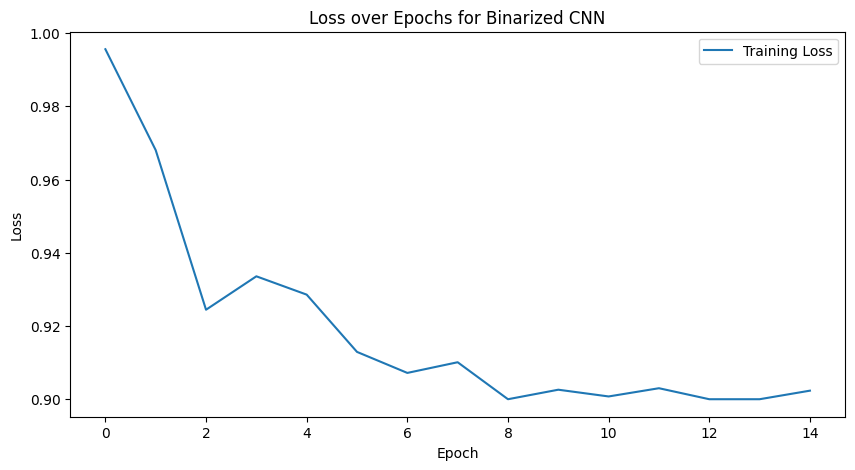

In [ ]:
plot_losses(binarized_hinge_sgd_losses)

In [ ]:
# Evaluate Binarized CNN
binarized_hinge_sgd_acc = evaluate_binarized(binarized_cnn_hinge_sgd, test_loader, 'Binarized CNN With HingleLoss and SGD')

Accuracy of the model Binarized CNN With HingleLoss and SGD on the test set: 17.26%


# Binarized CNN with Hingeloss and Adam

In [ ]:
# Let's use CrossEntropyLoss

binarized_cnn_hinge_adam = BinarizedCNN().to(device)

criterion = HingeLoss()
optimizer = torch.optim.Adam(binarized_cnn_hinge_adam.parameters(), lr=learning_rate)

binarized_hinge_adam_losses = train(binarized_cnn_hinge_adam, train_loader, optimizer, criterion, num_epochs, device)

Epoch: 1 | Loss: 0.900
Epoch: 2 | Loss: 0.900
Epoch: 3 | Loss: 0.900
Epoch: 4 | Loss: 0.900
Epoch: 5 | Loss: 0.900
Epoch: 6 | Loss: 0.900
Epoch: 7 | Loss: 0.900
Epoch: 8 | Loss: 0.900
Epoch: 9 | Loss: 0.900
Epoch: 10 | Loss: 0.900
Epoch: 11 | Loss: 0.900
Epoch: 12 | Loss: 0.900
Epoch: 13 | Loss: 0.900
Epoch: 14 | Loss: 0.900
Epoch: 15 | Loss: 0.900


In [ ]:
binarized_hinge_adam_acc = evaluate_binarized(binarized_cnn_hinge_adam, test_loader, 'Binarized CNN with CrossEntropyLoss and SGD optimizer')

Accuracy of the model Binarized CNN with CrossEntropyLoss and SGD optimizer on the test set: 21.26%


# Binarized CNN with cross entropy loss and SGD

In [ ]:
# Let's use CrossEntropyLoss and SGD

binarized_cnn_cross_sgd = BinarizedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(binarized_cnn_cross_sgd.parameters(), lr=learning_rate)

binarized_cross_sgd_losses = train(binarized_cnn_cross_sgd, train_loader, optimizer, criterion, num_epochs, device)

Epoch: 1 | Loss: 2.137
Epoch: 2 | Loss: 2.006
Epoch: 3 | Loss: 2.134
Epoch: 4 | Loss: 2.063
Epoch: 5 | Loss: 2.035
Epoch: 6 | Loss: 1.783
Epoch: 7 | Loss: 2.137
Epoch: 8 | Loss: 2.218
Epoch: 9 | Loss: 1.481
Epoch: 10 | Loss: 2.362
Epoch: 11 | Loss: 1.800
Epoch: 12 | Loss: 1.719
Epoch: 13 | Loss: 1.879
Epoch: 14 | Loss: 1.805
Epoch: 15 | Loss: 1.567


In [ ]:
binarized_cross_sgd_acc = evaluate_binarized(binarized_cnn_cross_sgd, test_loader, 'Binarized CNN with crossentropyloss and adam optmizer')

Accuracy of the model Binarized CNN with crossentropyloss and adam optmizer on the test set: 38.47%


# Binarized CNN with cross entropy loss and Adam optimizer

In [ ]:
# Let's use CrossEntropyLoss and Adam

binarized_cnn_cross_adam = BinarizedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(binarized_cnn_cross_adam.parameters(), lr=learning_rate)

binarized_cross_adam_losses = train(binarized_cnn_cross_adam, train_loader, optimizer, criterion, num_epochs, device)

Epoch: 1 | Loss: 1.432
Epoch: 2 | Loss: 1.492
Epoch: 3 | Loss: 1.374
Epoch: 4 | Loss: 1.619
Epoch: 5 | Loss: 0.899
Epoch: 6 | Loss: 1.346
Epoch: 7 | Loss: 0.963
Epoch: 8 | Loss: 1.228
Epoch: 9 | Loss: 1.434
Epoch: 10 | Loss: 1.599
Epoch: 11 | Loss: 1.231
Epoch: 12 | Loss: 1.143
Epoch: 13 | Loss: 1.072
Epoch: 14 | Loss: 1.027
Epoch: 15 | Loss: 1.390


In [ ]:
binarized_cross_adam_acc = evaluate_binarized(binarized_cnn_cross_adam, test_loader, 'Binarized CNN with crossentropyloss and adam optmizer')

Accuracy of the model Binarized CNN with crossentropyloss and adam optmizer on the test set: 62.35%


# Lets compare the resulted Accuracies from our experiments.

In [ ]:
import plotly.graph_objects as go

# Accuracies for each model configuration
models = [
    "CNN (Cross Entropy, Adam)",
    "CNN (Cross Entropy, SGD)",
    "Binarized CNN (Hinge Loss, SGD)",
    "Binarized CNN (Hinge Loss, Adam)",
    "Binarized CNN (Cross Entropy, SGD)",
    "Binarized CNN (Cross Entropy, Adam)"
]

accuracies = [
    cnn_adam_acc,
    cnn_sgd_acc,
    binarized_hinge_sgd_acc,
    binarized_hinge_adam_acc,
    binarized_cross_sgd_acc,
    binarized_cross_adam_acc
]

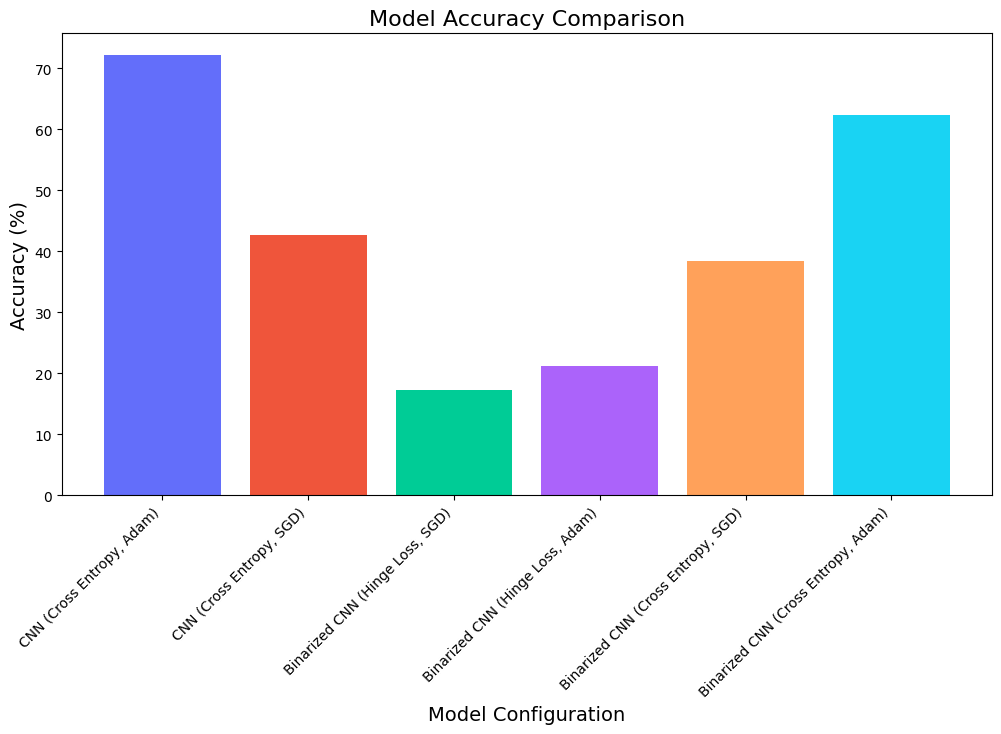

In [ ]:
from matplotlib.pyplot import plot, savefig

# Set up the figure
plt.figure(figsize=(12, 6))

# Create a bar chart
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3']
plt.bar(models, accuracies, color=colors)

# Add titles and labels
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Model Configuration", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)

# Rotate x labels for readability
plt.xticks(rotation=45, ha='right')

# Set a transparent background
plt.gca().set_facecolor((0, 0, 0, 0))  # Transparent background
plt.savefig("accuracy_comparison_matplotlib.png", transparent=True, dpi=300, bbox_inches="tight")

savefig('acc results.png', transparent=True)

# Show plot
plt.show()